# Importing Libraries

In [1]:
using MAT
using PyPlot
using ImageQuilting
using GeoStatsImages
using MultivariateStats
using Distances 

INFO: Precompiling module CLFFT.
ERROR: LoadError: LoadError: CLFFT not properly installed. Please run Pkg.build("CLFFT") then restart Julia.
Stacktrace:
 [1] error(::String) at .\error.jl:21
 [2] include_from_node1(::String) at .\loading.jl:576
 [3] include(::String) at .\sysimg.jl:14
 [4] include_from_node1(::String) at .\loading.jl:576
 [5] include(::String) at .\sysimg.jl:14
 [6] anonymous at .\<missing>:2
while loading C:\Users\ammilten\.julia\v0.6\CLFFT\src\api.jl, in expression starting on line 9
while loading C:\Users\ammilten\.julia\v0.6\CLFFT\src\CLFFT.jl, in expression starting on line 6


# Custom Functions

In [2]:
#Easy Plotting function
function plotImage(im)
    s=size(im);
    if s[1]==s[2]
        pcolormesh(transpose(im[:,end:-1:1]))
    else
        pcolormesh(im[end:-1:1,:])
    end
end;

In [3]:
#Easy function for making TIs from 2d arrays
function im2TI(im)
    s=size(im);
    TI=Array{Float64}(s[1],s[2],1);
    TI[:,:,1]=im;
    return TI;
end;

In [4]:
#Wrapper function for easy unconditional 2d image quilting simulation
function uncond_iqsim2d(TI,templ,nreals);
    TI2=im2TI(TI);
    sim=iqsim(TI2, templ..., size(TI2)..., nreal=nreals);
    return sim;
end;

In [5]:
#Wrapper function to loop through template sizes for unconditional simulations.
#templSizes must be a nx3 array where n is the number of templates to test
function templSizeTest(TI,templSizes,nreals)
    TI_size=size(TI)
    s=size(templSizes)
    
    out=Array{Array{Array{Float64,3},1}}(s[1])
    for i=1:s[1]
        println("Simulating Template $(i) of $(s[1])");
        out[i]=uncond_iqsim2d(TI, templSizes[i,:], nreals)
    end
    return out
end;

In [6]:
#This proximity transform function basically uses a v-shaped 
# function __/\__ near positive occurences. The value at each 
#pixel is determined by the nearest positive occurence. 
#A positive occurence is a pixel with a value of 1.

function proximityTransform(im,tol)
    
    s=size(im);
    prox=copy(im);

    #Loop through all pixels
    for i=1:s[1]
        for j=1:s[2]

            #For efficiency only sample around the points 
            #near events
            if im[i,j]==1

                #Subsample image near event
                l=i-tol;
                r=i+tol;
                u=j+tol;
                d=j-tol;

                #Account for edges in subsampling
                if u>s[2]
                    u=s[2];
                end
                if d<=0
                    d=1;
                end
                if r>s[1]
                    r=s[1];
                end
                if l<=0
                    l=1;
                end

                #Loop through subsampled image and transform
                for i2=l:r
                    for j2=d:u

                        #Compute distance to center pixel
                        dist=sqrt((i2-i)^2+(j2-j)^2);

                        #Compute prox transform value
                        val=max(1-dist/tol,0);

                        #Only assign if this is the nearest 
                        #occurence to the point
                        prox[i2,j2]=max(prox[i2,j2],val);
                    end
                end
            end
        end
    end
    return prox
end;

In [7]:
#Wrapper function to apply the proximity transform to each element in an array
function realProxTrans(reals,tol=30)
    N=length(reals)
    
    out=Array{Array{Float64,3},1}(N)
    
    for i=1:N
        out[i]=proximityTransform(reals[i],tol)
    end
    
    out
end
;

In [8]:
#Finds index of x nearest to val
function closest_index(x, val)
    ibest = start(eachindex(x))
    dxbest = abs(x[ibest]-val)
    for I in eachindex(x)
        dx = abs(x[I]-val)
        if dx < dxbest 
            dxbest = dx 
            ibest = I 
        end 
    end 
    ibest 
end; 

In [9]:
#Computes the average difference between data points
function meanDiff(x)
    diffs=x[2:end]-x[1:end-1];
    return mean(diffs)
end;

In [10]:
#This function does 3 things:
#    1. Clips and transposes binary image
#    2. Interpolates the enveloped image to match binary image dims
#    3. Computes the proximity transform of clipped binary image
#
#It is intended to be used to easily prepare my custom data for
#use in image quilting simulation

function prepareImages(st,proxTol=30)
    
    #Initial size
    s=size(st["binary"]);

    xAux=st["xTI"][1,:];
    xPrim=st["x"][22:end-21]; #There's padding
    
    #Compute average distance and use it to find proper indices for clipping
    md=meanDiff(st["xTI"]);
    ind1=closest_index(xPrim,xAux[1]-md);
    ind2=closest_index(xPrim,xAux[end]+md);
    
    #Initialize outputs
    outP=transpose(st["binary"][ind1:ind2,1:end-1]);
    outS=zeros(s[2]-1,ind2-ind1+1)
    
    #Interpolation
    for i=ind1:ind2
        ni=closest_index(xAux,xPrim[i]);
        outS[:,i-ind1+1]=st["sTI"][:,ni];
    end
    
    return im2TI(outP), im2TI(outS), im2TI(proximityTransform(outP,proxTol))
end;

In [11]:
#This function concatenates the conditional, unconditional, and training images then 
#computes a (2n+1)x(2n+1) distance matrix to be used for multidimensional scaling.
function distMat(A,B,TI,Ref)
    
    #Compute lengths
    NA=length(A)
    NB=length(B)
    
    #Total new length is the length A and B plus:
    #    1 for TI
    #    1 for Ref Image
    #    3 for past realizations
    #    -----------
    #    5 total
    N=NA+NB+2
       
    #Initialize output
    D=zeros(N,N)
    
    #Convert TI & Ref to proper form
    z1=Array{Array{Float64,3},1}(1)
    z1[1]=TI
    z2=Array{Array{Float64,3},1}(1)
    z2[1]=Ref
    
    #Concatenate realizations and training image
    Z=vcat(A,B,z1,z2)
    
    #Compute all distances
    for i=1:N
        for j=1:N
            D[i,j]=Distances.evaluate(Euclidean(),Z[i],Z[j])
        end
    end
    
    D
end
;

# 1. Initializations and Test Simulations

In [12]:
#Import Matlab Data
fracdata=matread("complete processed data.mat")

Dict{String,Any} with 8 entries:
  "R2_dmig"  => Dict{String,Any}(Pair{String,Any}("tmax", 3.99975e-8),Pair{Stri…
  "TI4_dmig" => Dict{String,Any}(Pair{String,Any}("tmax", 3.99975e-8),Pair{Stri…
  "TI2_dmig" => Dict{String,Any}(Pair{String,Any}("tmax", 3.99975e-8),Pair{Stri…
  "R1_dmig"  => Dict{String,Any}(Pair{String,Any}("tmax", 3.99975e-8),Pair{Stri…
  "R4_dmig"  => Dict{String,Any}(Pair{String,Any}("tmax", 3.99975e-8),Pair{Stri…
  "R3_dmig"  => Dict{String,Any}(Pair{String,Any}("tmax", 3.99975e-8),Pair{Stri…
  "TI3_dmig" => Dict{String,Any}(Pair{String,Any}("tmax", 3.99975e-8),Pair{Stri…
  "TI1_dmig" => Dict{String,Any}(Pair{String,Any}("tmax", 3.99975e-8),Pair{Stri…

In [13]:
#Show an example of the fields for each struct, just for reference
fracdata["R2_dmig"]

Dict{String,Any} with 22 entries:
  "tmax"          => 3.99975e-8
  "sTI"           => [0.00156502 0.00161257 … 0.00164644 0.00162116; 0.00164226…
  "x"             => [-0.042 -0.04 … 2.04 2.042]
  "dt"            => 7.5e-12
  "binary"        => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0…
  "env"           => [0.00156502 0.00161257 … 0.00164644 0.00162116; 0.00158022…
  "dmig"          => [-0.000398511 -0.000783725 … -0.000109158 -0.000812116; -0…
  "srcloc_x"      => [3.46945e-17 0.048 … 1.448 1.5]
  "zmig"          => [0.0 0.00042 … 2.11344 2.11386]
  "eps"           => [1.0 1.0 … 7.0 7.0; 1.0 1.0 … 7.0 7.0; … ; 1.0 1.0 … 7.0 7…
  "frequency_MHz" => 500.0
  "srcpulse"      => [5.43e-7 8.14486e-6 … 0.0 0.0]
  "mu"            => [1.0 1.0 … 1.025 1.025; 1.0 1.0 … 1.025 1.025; … ; 1.0 1.0…
  "recloc_x"      => [0.5 0.548 … 1.948 2.0]
  "z"             => [-0.102 -0.1 … 2.04 2.042]
  "pTI"           => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0…
  "npml"   

In [14]:
#Prepare all my data to have matching sizes before simulating
TI_prim, TI_aux, TI_prox = prepareImages(fracdata["TI2_dmig"]);
R_prim, R_aux, R_prox = prepareImages(fracdata["R2_dmig"]);

#Number of realizations
n=10;

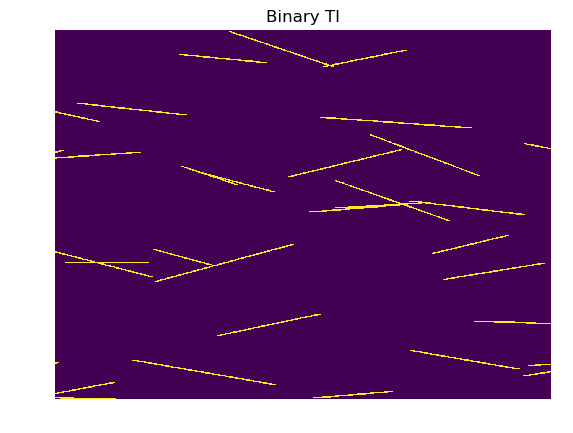

In [15]:
#Plot image to be used
plotImage(TI_prim);
title("Binary TI");
axis("off");

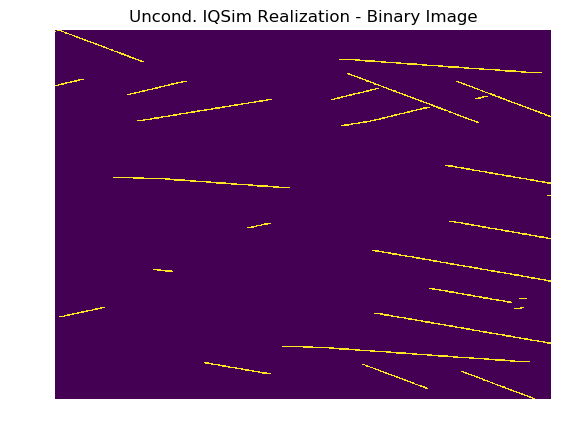

In [16]:
#Perform Test Simulation on binary image
binary_uncond = uncond_iqsim2d(TI_prim, [101 101 1], n);

#Plot results
plotImage(binary_uncond[1][:,:,1]);
title("Uncond. IQSim Realization - Binary Image");
axis("off");

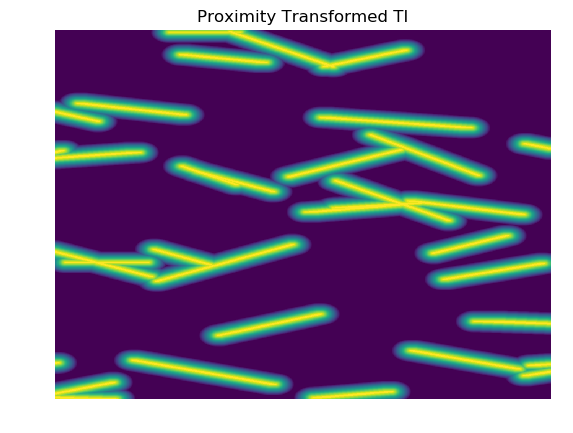

In [17]:
#Plot proximity transform
plotImage(TI_prox);
title("Proximity Transformed TI");
axis("off");

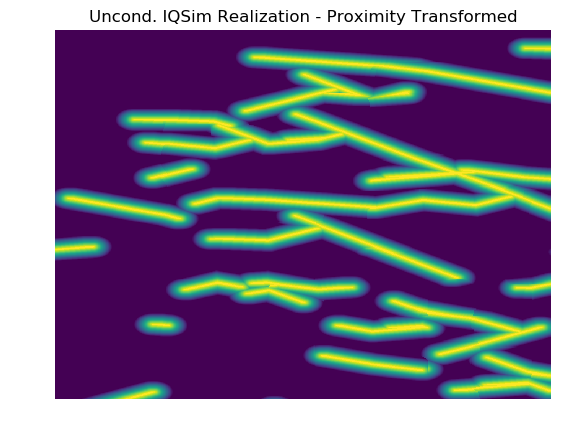

In [18]:
#Perform test IQ Simulation on proximity-transformed image
prox_uncond = uncond_iqsim2d(TI_prox, [101 101 1], n);

#Plot realization
plotImage(prox_uncond[1][:,:,1]);
title("Uncond. IQSim Realization - Proximity Transformed");
axis("off");

This image quiliting technique is really incredible. I can't believe how fast it is and how it produces much more visually appealing images than typical MPS simulations. One slightly concerning observation is that this algorithm, at least with this template size, sometimes produces much longer fractures than the training image contains. I have a feeling this is a template size phenomenon but nonetheless something worth noting. Also, the algorithm works basically the same for data with and without the proximity transform.  

# 2. Template Size Testing

In [19]:
#Define template sizes
templSizes=[51 51 1; 76 76 1; 101 101 1; 201 201 1];

In [20]:
#Template size test without proximity transform
binary_templSizeTest=templSizeTest(TI_prim,templSizes,3);

#With proximity transform
prox_templSizeTest=templSizeTest(TI_prox,templSizes,3);

Simulating Template 1 of 4
Simulating Template 2 of 4
Simulating Template 3 of 4
Simulating Template 4 of 4
Simulating Template 1 of 4
Simulating Template 2 of 4
Simulating Template 3 of 4
Simulating Template 4 of 4


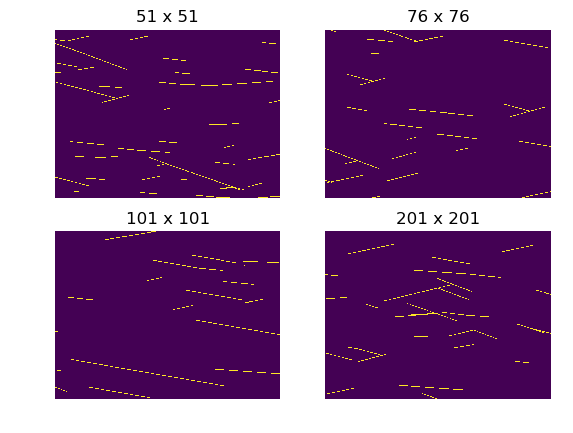

In [21]:
#Plot template size test results (realization 1) for binary
titles=["51 x 51", "76 x 76", "101 x 101", "201 x 201"]
for i=1:4
    subplot(2,2,i)
    plotImage(binary_templSizeTest[i][1][:,:,1])
    axis("off")
    title(titles[i])
end

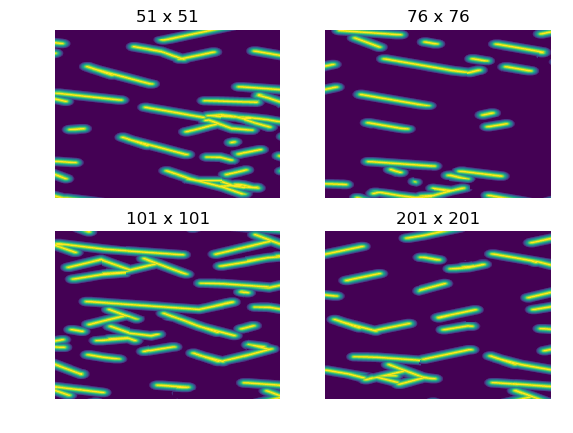

In [22]:
#Plot template size test results for proximity transform
for i=1:4
    subplot(2,2,i)
    plotImage(prox_templSizeTest[i][1][:,:,1])
    axis("off")
    title(titles[i])
end

# 3. Using Secondary Data

In [23]:
#Conditional image quilting simulation - no proximity transform
binary_cond=iqsim(TI_prim,151,151,1,size(TI_prim)..., soft=[(im2TI(R_aux),im2TI(TI_aux))],nreal=n,overlapx=1/10,overlapy=1/10)

#Conditional image quilting simulation with proximity transform
prox_cond=iqsim(TI_prox,151,151,1,size(TI_prox)..., soft=[(im2TI(R_aux),im2TI(TI_aux))],nreal=n,overlapx=1/10,overlapy=1/10)
;


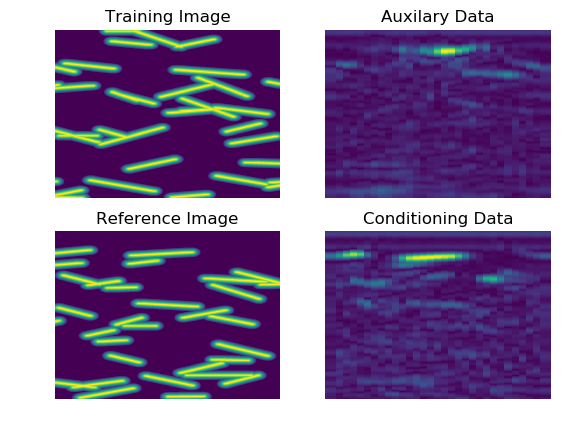

In [24]:
subplot(2,2,1)
plotImage(TI_prox[:,:,1])
axis("off")
title("Training Image")
subplot(2,2,2)
plotImage(TI_aux[:,:,1])
axis("off")
title("Auxilary Data")
subplot(2,2,3)
plotImage(R_prox[:,:,1])
axis("off")
title("Reference Image")
subplot(2,2,4)
plotImage(R_aux[:,:,1])
axis("off")
title("Conditioning Data")
;

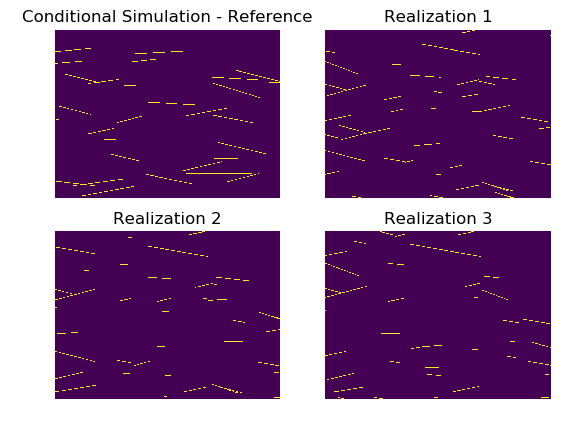

In [25]:
subplot(2,2,1)
plotImage(R_prim)
axis("off")
title("Conditional Simulation - Reference")
for i=1:3
    subplot(2,2,i+1)
    plotImage(binary_cond[i][:,:,1])
    axis("off")
    title("Realization $(i)")
end
;

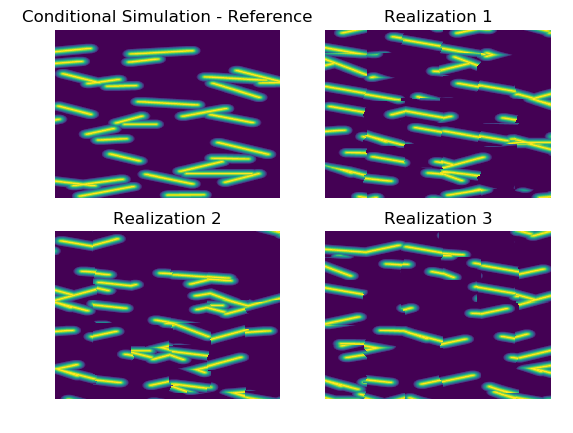

In [26]:
subplot(2,2,1)
plotImage(R_prox)
axis("off")
title("Conditional Simulation - Reference")
for i=1:3
    subplot(2,2,i+1)
    plotImage(prox_cond[i][:,:,1])
    axis("off")
    title("Realization $(i)")
end
;

# 4. Assess Spatial Uncertainty

In [27]:
#Load Wavesim MPS simulations
wavesim=matread("conditional sims.mat")

#Convert those realizations to our standard training image format
cond_wavesim_mat=wavesim["sim2"]["results"]
cond_wavesim=Array{Array{Float64,3},1}(3)

for k=1:3
    z=reshape(cond_wavesim_mat[:,k],1000,31)

    #Initial size
    st=fracdata["TI2_dmig"]
    s=size(st["binary"]);

    xAux=st["xTI"][1,:];
    xPrim=st["x"][22:end-21]; #There's padding

    #Compute average distance and use it to find proper indices for clipping
    md=meanDiff(st["xTI"]);
    ind1=closest_index(xPrim,xAux[1]-md);
    ind2=closest_index(xPrim,xAux[end]+md);

    #Initialize outputs
    z2=zeros(s[2]-1,ind2-ind1+1)

    #Interpolation
    for i=ind1:ind2
        ni=closest_index(xAux,xPrim[i]);
        z2[:,i-ind1+1]=z[:,ni];
    end
    
    cond_wavesim[k]=im2TI(z2)
end
;

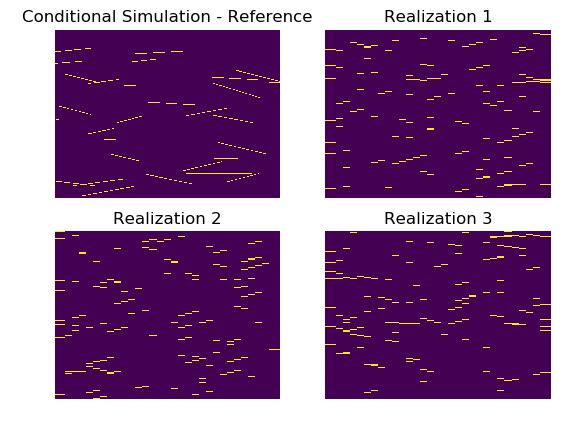

In [28]:
#Plot Wavesim realizations
subplot(2,2,1)
plotImage(R_prim)
axis("off")
title("Conditional Simulation - Reference")
for i=1:3
    subplot(2,2,i+1)
    plotImage(cond_wavesim[i][:,:,1])
    axis("off")
    title("Realization $(i)")
end
;

In [29]:
#Compute distance matrix for proximity-transformed simulations and perform MDS
D_prox=distMat(prox_uncond,prox_cond,TI_prox,R_prox)
mds_prox=classical_mds(D_prox,2);

#Same for binary simulations, but we apply prox transform to realizations first
D_binary=distMat(realProxTrans(binary_uncond),vcat(realProxTrans(binary_cond),realProxTrans(cond_wavesim)),TI_prox,R_prox)
mds_binary=classical_mds(D_binary,2);


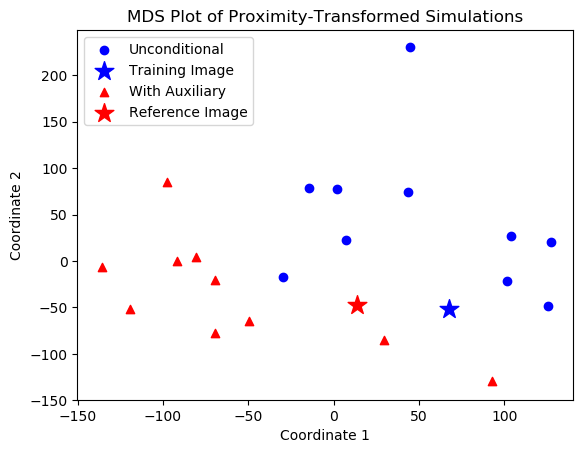

In [30]:
#Plot the results of the MDS for proximity-transformed simulations
s1=scatter(mds_prox[1,1:n],mds_prox[2,1:n],marker="o",c="b")
s2=scatter(mds_prox[1,n+1:n*2],mds_prox[2,n+1:n*2],marker="^",c="r")
s3=scatter(mds_prox[1,end-1],mds_prox[2,end-1],marker="*",s=200,c="b")
s4=scatter(mds_prox[1,end],mds_prox[2,end],marker="*",s=200,c="r")

legend((s1,s3,s2,s4),("Unconditional","Training Image","With Auxiliary","Reference Image"))
xlabel("Coordinate 1")
ylabel("Coordinate 2")
title("MDS Plot of Proximity-Transformed Simulations")
;


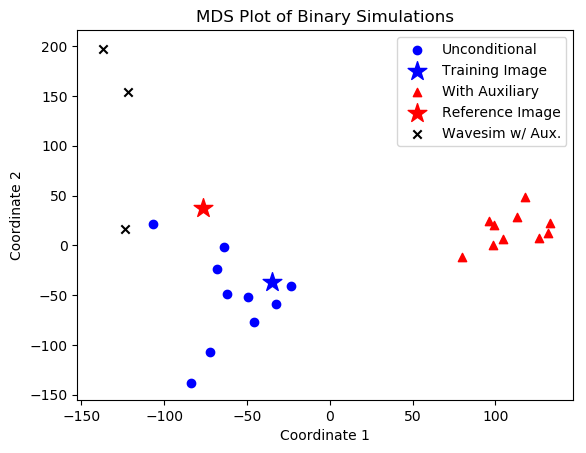

In [31]:
#Plot the results of the MDS for binary simulations
s1=scatter(mds_binary[1,1:n],mds_binary[2,1:n],marker="o",c="b")
s2=scatter(mds_binary[1,n+1:n*2],mds_binary[2,n+1:n*2],marker="^",c="r")
s3=scatter(mds_binary[1,end-1],mds_binary[2,end-1],marker="*",s=200,c="b")
s4=scatter(mds_binary[1,end],mds_binary[2,end],marker="*",s=200,c="r")
s5=scatter(mds_binary[1,n*2+1:n*2+3],mds_binary[2,n*2+1:n*2+3],marker="x",c="k")

legend((s1,s3,s2,s4,s5),("Unconditional","Training Image","With Auxiliary","Reference Image","Wavesim w/ Aux."))
xlabel("Coordinate 1")
ylabel("Coordinate 2")
title("MDS Plot of Binary Simulations")
;